In [ ]:
  # ====== Drive mount & unzip (same as your original) ======
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.listdir("/content/drive/MyDrive")


['Lathe and Milling Machine.gdoc',
 'medicalinsurance.pdf',
 'Colab Notebooks',
 '2nd_merged.pdf',
 'Linux Desktop Apeireon.gdoc',
 'EE205_assignment.gdoc',
 'Untitled document (1).gdoc',
 'Application for Employment_Internship.pdf',
 'Application for Employment_Internship.gdoc',
 'ML_lead.png',
 '2201ee72_tpc_undertaking.pdf',
 'img1.jpg',
 'Attendance_Photos',
 'Important questions.gsheet',
 'Untitled document.gdoc',
 'skin_disease.zip',
 'checkpoint-435',
 'swin-finetuned-skindisease-kan']

In [ ]:
# ====== Install required packages ======
!pip install --upgrade transformers datasets evaluate timm scikit-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 132.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 148.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 19.2 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login()

True

In [ ]:
!unzip /content/drive/MyDrive/skin_disease.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-2.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-3.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-10.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-100.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-101.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-102.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-103.jpeg  
  inflating: /content/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-104.jpeg  
  inflating: /content/Skin

In [ ]:
import torch
import evaluate
import numpy as np
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
    EarlyStoppingCallback,
    set_seed,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

In [ ]:
# ====== Imports & baseline constants (copied from your script) ======

MODEL_CHECKPOINT = "/content/drive/MyDrive/checkpoint-435"
MODEL_VANILLA_CHECKPOINT = "microsoft/swin-base-patch4-window7-224"
DATA_DIR = "/content/SkinDisease/SkinDisease"
OUTPUT_DIR = "/content/drive/MyDrive/swin-finetuned-skindisease-kan"
NUM_LABELS = 22
BATCH_SIZE = 16
SEED = 42
EPOCHS = 10

In [ ]:
# ====== Dataset loading + preprocessing (unchanged) ======
print("Loading and splitting the dataset...")
full_dataset = load_dataset("imagefolder", data_dir=DATA_DIR)
val_test_split = full_dataset['test'].train_test_split(test_size=0.2, seed=SEED)
dataset = DatasetDict({
    'train': full_dataset['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})
print("Dataset successfully split:")
print(dataset)

labels = dataset["train"].features["label"].names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}

image_processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
def transform(examples):
    inputs = image_processor(examples["image"], return_tensors="pt")
    inputs["labels"] = examples["label"]
    return inputs
processed_dataset = dataset.with_transform(transform)

Loading and splitting the dataset...


Resolving data files:   0%|          | 0/13893 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1546 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset successfully split:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13893
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 1236
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 310
    })
})


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# ====== Load original Swin model (same as baseline) ======
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [ ]:
# ====== Training arguments (identical to your original) ======

training_args = TrainingArguments(
    output_dir = OUTPUT_DIR,
    remove_unused_columns = False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCHS,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = "loss",
    greater_is_better = False,
    fp16 = True,
    push_to_hub = False,
    report_to = "wandb",
    run_name = "swin-kan-finetune",
    logging_steps = 10,
)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1}


early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=3)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.cuda.amp as amp
import copy


class KANLinear(nn.Module):
    """
    Drop-in replacement for nn.Linear that:
      - Keeps the same interface: forward(x) -> linear-like output
      - Copies weight + bias from an existing nn.Linear
      - Adds a tiny KAN-style spline correction on top of the linear output
      - Does spline math in fp32 for stability under AMP/fp16

    Design: y = Linear(x) + tiny_spline(Linear(x))
    At init: tiny_spline ~ 0, so we recover pretrained behavior.
    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        bias: bool = True,
        num_spline_terms: int = 3,
        init_spline_scale: float = 1e-3,
        use_fp32_spline: bool = True,
    ):
        super().__init__()
        # Base linear (will be initialized from pretrained Swin)
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.num_spline_terms = num_spline_terms
        self.use_fp32_spline = use_fp32_spline

        if num_spline_terms > 0:
            # KAN / spline parameters
            self.spline_weight = nn.Parameter(
                torch.zeros(out_features, num_spline_terms)
            )
            self.spline_bias = nn.Parameter(torch.zeros(out_features))

            # Tiny init so we start close to pure linear
            nn.init.normal_(self.spline_weight, mean=0.0, std=init_spline_scale)
            nn.init.zeros_(self.spline_bias)
        else:
            self.register_parameter("spline_weight", None)
            self.register_parameter("spline_bias", None)

    # ---- internal core ----
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        """
        Core logic. Assumes x is already float32 if we're using fp32 mode.
        IMPORTANT: no activation here; Swin's GELU stays in the MLP block.
        """
        base = self.linear(x)  # (B, ..., out_features)

        if self.num_spline_terms <= 0 or self.spline_weight is None:
            return base

        # Simple polynomial KAN-ish correction on the *linear output*
        # powers: (..., out_features, num_spline_terms)
        powers = torch.stack(
            [base ** (k + 1) for k in range(self.num_spline_terms)], dim=-1
        )

        # spline: (..., out_features)
        spline = torch.einsum("...od,od->...o", powers, self.spline_weight)
        spline = spline + self.spline_bias

        return base + spline

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Keep spline math in fp32 even if autocast is enabled
        if not self.use_fp32_spline:
            return self._forward_impl(x)

        orig_dtype = x.dtype
        with amp.autocast(enabled=False):
            x32 = x.to(torch.float32)
            out32 = self._forward_impl(x32)
        return out32.to(orig_dtype)

    # ---- regularization hook used by KANTrainer ----
    def regularization_loss(self, regularize_activation: float = 1.0, regularize_entropy: float = 0.5):
        """
        Simple L2 regularization on spline parameters.
        Signature matches how KANTrainer calls it.
        """
        if self.spline_weight is None:
            # Return a proper tensor on the correct device
            return self.linear.weight.new_tensor(0.0)

        reg_w = (self.spline_weight ** 2).mean()
        reg_b = (self.spline_bias ** 2).mean()
        return reg_w + reg_b

    # ---- helper: build from an existing Linear ----
    @classmethod
    def from_linear(
        cls,
        linear: nn.Linear,
        num_spline_terms: int = 3,
        init_spline_scale: float = 1e-3,
        use_fp32_spline: bool = True,
    ) -> "KANLinear":
        """
        Create a KANLinear initialized from a pretrained nn.Linear.
        """
        kan = cls(
            in_features=linear.in_features,
            out_features=linear.out_features,
            bias=(linear.bias is not None),
            num_spline_terms=num_spline_terms,
            init_spline_scale=init_spline_scale,
            use_fp32_spline=use_fp32_spline,
        )

        # Copy base linear weights and bias
        with torch.no_grad():
            kan.linear.weight.copy_(linear.weight)
            if linear.bias is not None and kan.linear.bias is not None:
                kan.linear.bias.copy_(linear.bias)

        return kan


In [ ]:
def replace_mlp_with_kan(
    model: nn.Module,
    use_kan_fc1: bool = True,
    kan_kwargs: dict | None = None,
    init_from_linear: bool = True,
) -> nn.Module:
    """
    In-place: find all MLP-like modules in the Swin backbone (modules that
    have .fc1 and .fc2 as nn.Linear) and replace their fc1 with KANLinear.

    This way we don't depend on the exact class name (Mlp/SwinMLP/etc.)
    from transformers. We just look for the standard Swin MLP structure.
    """
    if kan_kwargs is None:
        kan_kwargs = {}

    for module in model.modules():
        # Identify MLP blocks by structure, not by class name
        if hasattr(module, "fc1") and hasattr(module, "fc2"):
            if use_kan_fc1 and isinstance(module.fc1, nn.Linear):
                old_fc1 = module.fc1

                if init_from_linear:
                    new_fc1 = KANLinear.from_linear(
                        old_fc1,
                        **kan_kwargs,
                    )
                else:
                    new_fc1 = KANLinear(
                        old_fc1.in_features,
                        old_fc1.out_features,
                        bias=(old_fc1.bias is not None),
                        **kan_kwargs,
                    )

                module.fc1 = new_fc1

    return model

import random
def replace_mlp_with_kan_random(
    model: nn.Module,
    use_kan_fc1: bool = True,
    kan_kwargs: dict | None = None,
    init_from_linear: bool = True,
    replace_prob: float = 1.0,          # 1.0 → replace all, 0.5 → ~half, 0.0 → none
    rng: random.Random | None = None,   # optional RNG for reproducibility
) -> nn.Module:
    """
    In-place: find all MLP-like modules in the Swin backbone (modules that
    have .fc1 and .fc2 as nn.Linear) and replace their fc1 with KANLinear.

    Now only a random subset of those MLPs are replaced, controlled by
    `replace_prob`.
    """
    if kan_kwargs is None:
        kan_kwargs = {}

    if rng is None:
        rng = random  # use global RNG by default

    for module in model.modules():
        # Identify MLP blocks by structure, not by class name
        if hasattr(module, "fc1") and hasattr(module, "fc2"):
            if use_kan_fc1 and isinstance(module.fc1, nn.Linear):
                # With probability (replace_prob), replace this layer
                if replace_prob < 1.0:
                    if rng.random() > replace_prob:
                        continue  # skip replacing this particular MLP

                old_fc1 = module.fc1

                if init_from_linear:
                    new_fc1 = KANLinear.from_linear(
                        old_fc1,
                        **kan_kwargs,
                    )
                else:
                    new_fc1 = KANLinear(
                        old_fc1.in_features,
                        old_fc1.out_features,
                        bias=(old_fc1.bias is not None),
                        **kan_kwargs,
                    )

                module.fc1 = new_fc1

    return model


In [ ]:
# ====== KAN-aware Trainer that injects small KAN regularization ======
from transformers import Trainer

class KANTrainer(Trainer):

    def __init__(self, *args, kan_regularization_weight=1e-4, **kwargs):
        super().__init__(*args, **kwargs)
        self.kan_reg_w = kan_regularization_weight

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        How the loss is computed by Trainer. By default, all models return the loss
        in the first element.

        Subclass and override this if your model returns something different!
        """
        outputs = model(**inputs)
        loss = outputs.loss if hasattr(outputs, 'loss') else outputs['loss']
        reg = 0.0
        for n, m in model.named_modules():
            if hasattr(m, 'regularization_loss'):
                try:
                    reg = reg + m.regularization_loss(regularize_activation=1.0, regularize_entropy=0.5)
                except Exception:
                    pass

        total_loss = loss + self.kan_reg_w * reg
        return (total_loss, outputs) if return_outputs else total_loss

In [ ]:
# A more robust inspection code to find ALL linear layers
print("Inspecting all Linear layers in the model...")
found_linear_layers = False
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Found Linear Layer: '{name}' with shape (in: {module.in_features}, out: {module.out_features})")
        found_linear_layers = True

if not found_linear_layers:
    print("!!! No nn.Linear layers were found in the model. This is highly unusual. !!!")

# Then call your replacement function
# model = replace_mlp_with_kan(...)

Inspecting all Linear layers in the model...
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.query' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.key' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.self.value' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.attention.output.dense' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.intermediate.dense' with shape (in: 128, out: 512)
Found Linear Layer: 'swin.encoder.layers.0.blocks.0.output.dense' with shape (in: 512, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.query' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.key' with shape (in: 128, out: 128)
Found Linear Layer: 'swin.encoder.layers.0.blocks.1.attention.self.value' with shape (in: 128, out: 128)
Found Linear Layer: 's

In [ ]:
import random
import torch.nn as nn

def replace_swin_mlp_with_kan_random(
    model: nn.Module,
    use_kan_fc1: bool = True,
    kan_kwargs: dict | None = None,
    init_from_linear: bool = True,
    replace_prob: float = 1.0,          # 1.0 = all, 0.5 ≈ half
    rng: random.Random | None = None,
) -> nn.Module:
    """
    Replace the 'intermediate.dense' (MLP fc1) in Swin/ViT-style encoder blocks
    with KANLinear, optionally only for a random subset of blocks.

    We detect blocks by the presence of `.intermediate` and `.output` submodules
    (BERT-style naming used in many Hugging Face vision transformers).
    """
    if kan_kwargs is None:
        kan_kwargs = {}
    if rng is None:
        rng = random

    total_mlp_blocks = 0
    replaced_blocks = 0

    for block in model.modules():
        # BERT/ViT/Swin-style transformer block with FFN: intermediate + output
        if hasattr(block, "intermediate") and hasattr(block, "output"):
            if not hasattr(block.intermediate, "dense"):
                continue
            dense1 = block.intermediate.dense

            if use_kan_fc1 and isinstance(dense1, nn.Linear):
                total_mlp_blocks += 1

                # random selection
                if replace_prob < 1.0 and rng.random() > replace_prob:
                    continue

                old_fc1 = dense1

                if init_from_linear:
                    new_fc1 = KANLinear.from_linear(
                        old_fc1,
                        **kan_kwargs,
                    )
                else:
                    new_fc1 = KANLinear(
                        old_fc1.in_features,
                        old_fc1.out_features,
                        bias=(old_fc1.bias is not None),
                        **kan_kwargs,
                    )

                block.intermediate.dense = new_fc1
                replaced_blocks += 1

    print(f"[KAN] Replaced {replaced_blocks}/{total_mlp_blocks} MLP fc1 layers with KANLinear.")
    return model


In [ ]:
# ====== Apply replacement (KAN only on fc1) and init from pretrained weights ======

kan_opts = dict(
    num_spline_terms=3,       # degree of polynomial KAN correction
    init_spline_scale=1e-3,   # keep initial correction tiny
    use_fp32_spline=True,     # spline in float32 even with fp16 training
)


model = replace_swin_mlp_with_kan_random(
    model,
    use_kan_fc1=True,
    replace_prob=0.25,
    kan_kwargs=kan_opts,
    init_from_linear=True,
)


[KAN] Replaced 8/24 MLP fc1 layers with KANLinear.


In [ ]:
def print_all_layer_names(model):
    """
    Prints the full hierarchical name of every submodule in the model.
    Equivalent to what you showed above, but name-only.
    """
    print("\nInspecting all layers in the model...\n")

    for name, _ in model.named_modules():
        if name == "":  # skip the root module name
            continue
        print(name)

def print_kan_layers(model):
    print("\nKANLinear layers in the model:\n")
    count = 0
    for name, module in model.named_modules():
        if isinstance(module, KANLinear):
            print(name, "->", type(module).__name__)
            count += 1
    print(f"\nTotal KANLinear layers: {count}")

print_kan_layers(model)


KANLinear layers in the model:

swin.encoder.layers.0.blocks.1.intermediate.dense -> KANLinear
swin.encoder.layers.1.blocks.0.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.2.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.3.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.4.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.7.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.11.intermediate.dense -> KANLinear
swin.encoder.layers.2.blocks.12.intermediate.dense -> KANLinear

Total KANLinear layers: 8


In [ ]:
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl

class TrainingStatsCallback(TrainerCallback):
    """
    A custom callback to log detailed training statistics to Weights & Biases,
    including learning rates, gradient norms, and parameter norms for different
    parameter groups.
    """
    def on_step_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, model: nn.Module, optimizer: torch.optim.Optimizer, **kwargs):
        """
        Event called at the end of a training step.
        """
        # Log only every `logging_steps` to avoid cluttering the logs and slowing down training
        if state.global_step % args.logging_steps == 0:

            # --- 1. Log Learning Rates ---
            # The optimizer has param_groups that store the LR for each part of the model
            if optimizer is not None and hasattr(optimizer, 'param_groups'):
                lr_logs = {}
                for i, group in enumerate(optimizer.param_groups):
                    # We make an assumption about the group order based on how we created them
                    group_name = f"group_{i}"
                    if i == 0: group_name = "spline_params"
                    if i == 1: group_name = "head_params"
                    if i == 2: group_name = "backbone_params" # This group only exists in Stage B
                    lr_logs[f'lr/{group_name}'] = group['lr']
                wandb.log(lr_logs, step=state.global_step)

            # --- 2. Log Gradient and Weight Norms ---
            # This requires iterating through the named parameters of the model
            grad_norms = {"grad_norm/total": 0.0}
            weight_norms = {"weight_norm/total": 0.0}

            param_groups = {
                "spline": [],
                "head": [],
                "backbone": []
            }

            # First, categorize parameters
            for n, p in model.named_parameters():
                if p.grad is None: continue
                if 'spline' in n:
                    param_groups["spline"].append(p)
                elif 'classifier' in n or 'head' in n:
                    param_groups["head"].append(p)
                else:
                    param_groups["backbone"].append(p)

            # Calculate norms for each group
            for name, params in param_groups.items():
                if not params: continue

                # Gradient Norm
                total_grad_norm_group = torch.stack([p.grad.detach().norm(2) for p in params]).norm(2).item()
                grad_norms[f'grad_norm/{name}'] = total_grad_norm_group
                grad_norms["grad_norm/total"] += total_grad_norm_group**2

                # Weight Norm
                total_weight_norm_group = torch.stack([p.detach().norm(2) for p in params]).norm(2).item()
                weight_norms[f'weight_norm/{name}'] = total_weight_norm_group

            grad_norms["grad_norm/total"] = grad_norms["grad_norm/total"]**0.5
            wandb.log(grad_norms, step=state.global_step)
            wandb.log(weight_norms, step=state.global_step)

In [ ]:
import torch.nn as nn

def count_mlp_and_kan(model):
    total_mlp_blocks = 0
    kan_replaced = 0

    for name, module in model.named_modules():
        if hasattr(module, "fc1") and hasattr(module, "fc2"):
            # We consider this an MLP-like block
            total_mlp_blocks += 1
            if isinstance(module.fc1, KANLinear):
                kan_replaced += 1
                print(f"[KAN] fc1 replaced in block: {name}")

    print(f"\nTotal MLP-like blocks: {total_mlp_blocks}")
    print(f"Blocks with KAN fc1:   {kan_replaced}")
    if total_mlp_blocks > 0:
        print(f"Replacement ratio:     {kan_replaced / total_mlp_blocks:.3f}")

    return total_mlp_blocks, kan_replaced


In [ ]:
# Make a copy of the original model for comparison
orig_model = copy.deepcopy(model).eval()

# Apply KAN replacement
model = replace_swin_mlp_with_kan_random(model, use_kan_fc1=True,replace_prob = 0.5 ,kan_kwargs=kan_opts, init_from_linear=True).eval()

# Random input (same size as your images)
x = torch.randn(2, 3, 224, 224)

with torch.no_grad():
    y_orig = orig_model(x)
    y_kan = model(x)

max_diff = (y_orig.logits - y_kan.logits).abs().max().item()
count_mlp_and_kan(model)
print("Max abs diff between original Swin and Swin+KAN at init:", max_diff)


[KAN] Replaced 4/11 MLP fc1 layers with KANLinear.


/tmp/ipython-input-1345379983.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=False):



Total MLP-like blocks: 0
Blocks with KAN fc1:   0
Max abs diff between original Swin and Swin+KAN at init: 0.5780608654022217


In [ ]:
# ====== Two-stage training orchestration ======

# Stage A: freeze most parameters, train spline params + head only
for n, p in model.named_parameters():
    p.requires_grad = False

# Unfreeze classifier head params (common naming in HuggingFace models)
for n, p in model.named_parameters():
    if ('classifier' in n) or ('head' in n) or ('label_classifier' in n):
        p.requires_grad = True

# Unfreeze spline-related params
for n, p in model.named_parameters():
    if 'spline' in n or 'spline_weight' in n or 'spline_scaler' in n:
        p.requires_grad = True
    # Allow bias and norm params in head to train
    if ('bias' in n) and (('classifier' in n) or ('head' in n)):
        p.requires_grad = True
    if 'LayerNorm' in n or 'layernorm' in n or 'layer_norm' in n:
        p.requires_grad = True

from torch.optim import AdamW
# param groups for stageA
spline_params = [p for n,p in model.named_parameters() if p.requires_grad and ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)]
head_params = [p for n,p in model.named_parameters() if p.requires_grad and (('classifier' in n) or ('head' in n) or ('label_classifier' in n))]

# Get the names of spline and head parameters for efficient checking
spline_param_names = {n for n,p in model.named_parameters() if p.requires_grad and ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)}
head_param_names = {n for n,p in model.named_parameters() if p.requires_grad and (('classifier' in n) or ('head' in n) or ('label_classifier' in n))}

# Correctly define other_params using parameter names
other_params = [p for n,p in model.named_parameters() if p.requires_grad and (n not in spline_param_names and n not in head_param_names)]

param_groups_A = []
if spline_params:
    param_groups_A.append({"params": spline_params, "lr": 5e-4})
if head_params:
    param_groups_A.append({"params": head_params, "lr": 5e-5})
if other_params:
    param_groups_A.append({"params": other_params, "lr": 5e-5})

# Removed explicit weight_decay from AdamW constructor
optimizer_stageA = AdamW(param_groups_A)

# Stage A training args: reuse training_args but shorter epochs for warm-up
training_args_stageA = training_args
training_args_stageA.num_train_epochs = 4

# Explicitly initialize wandb with a higher timeout
import wandb
wandb.init(settings=wandb.Settings(init_timeout=120))

trainer_stageA = KANTrainer(
    model=model,
    args=training_args_stageA,
    data_collator=DefaultDataCollator(),
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, TrainingStatsCallback()],
    optimizers=(optimizer_stageA, None),
    kan_regularization_weight=1e-4,
)

print("Starting Stage A (warm spline+head training)...")
trainer_stageA.train()
print("Stage A finished.")

# Stage B: unfreeze all and fine-tune with careful LR groups
for n, p in model.named_parameters():
    p.requires_grad = True

param_groups_B = [
    {"params": [p for n,p in model.named_parameters() if ('spline' in n or 'spline_weight' in n or 'spline_scaler' in n)], "lr": 5e-4},
    {"params": [p for n,p in model.named_parameters() if ('classifier' in n or 'head' in n or 'label_classifier' in n)], "lr": 5e-5},
    {"params": [p for n,p in model.named_parameters() if not ('spline' in n or 'classifier' in n or 'head' in n or 'label_classifier' in n)], "lr": 5e-6}
]
# Removed explicit weight_decay from AdamW constructor
optimizer_stageB = AdamW(param_groups_B)

# Restore epoch count back to original (or desired)
training_args.num_train_epochs = EPOCHS

trainer_stageB = KANTrainer(
    model=model,
    args=training_args,
    data_collator=DefaultDataCollator(),
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback,TrainingStatsCallback()],
    optimizers=(optimizer_stageB, None),
    kan_regularization_weight=1e-5,
)

print("Starting Stage B (full fine-tune)...")
trainer_stageB.train()
print("Stage B finished.")

CommError: Run initialization has timed out after 120.0 sec. Please try increasing the timeout with the `init_timeout` setting: `wandb.init(settings=wandb.Settings(init_timeout=120))`.


=== Final evaluation on the hold-out test set ===


/tmp/ipython-input-1345379983.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=False):



--- Final Test Set Metrics (KAN) ---
eval_loss: 0.7281
eval_accuracy: 0.8161
eval_f1: 0.8150
eval_runtime: 9.5704
eval_samples_per_second: 32.3910
eval_steps_per_second: 2.0900
epoch: 5.0000
----------------------------

Generating predictions for confusion matrix...


/tmp/ipython-input-1345379983.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=False):


logits shape: (310, 22)
y_true shape: (310,)
Number of classes: 22
Classes: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']
Confusion matrix shape: (22, 22)


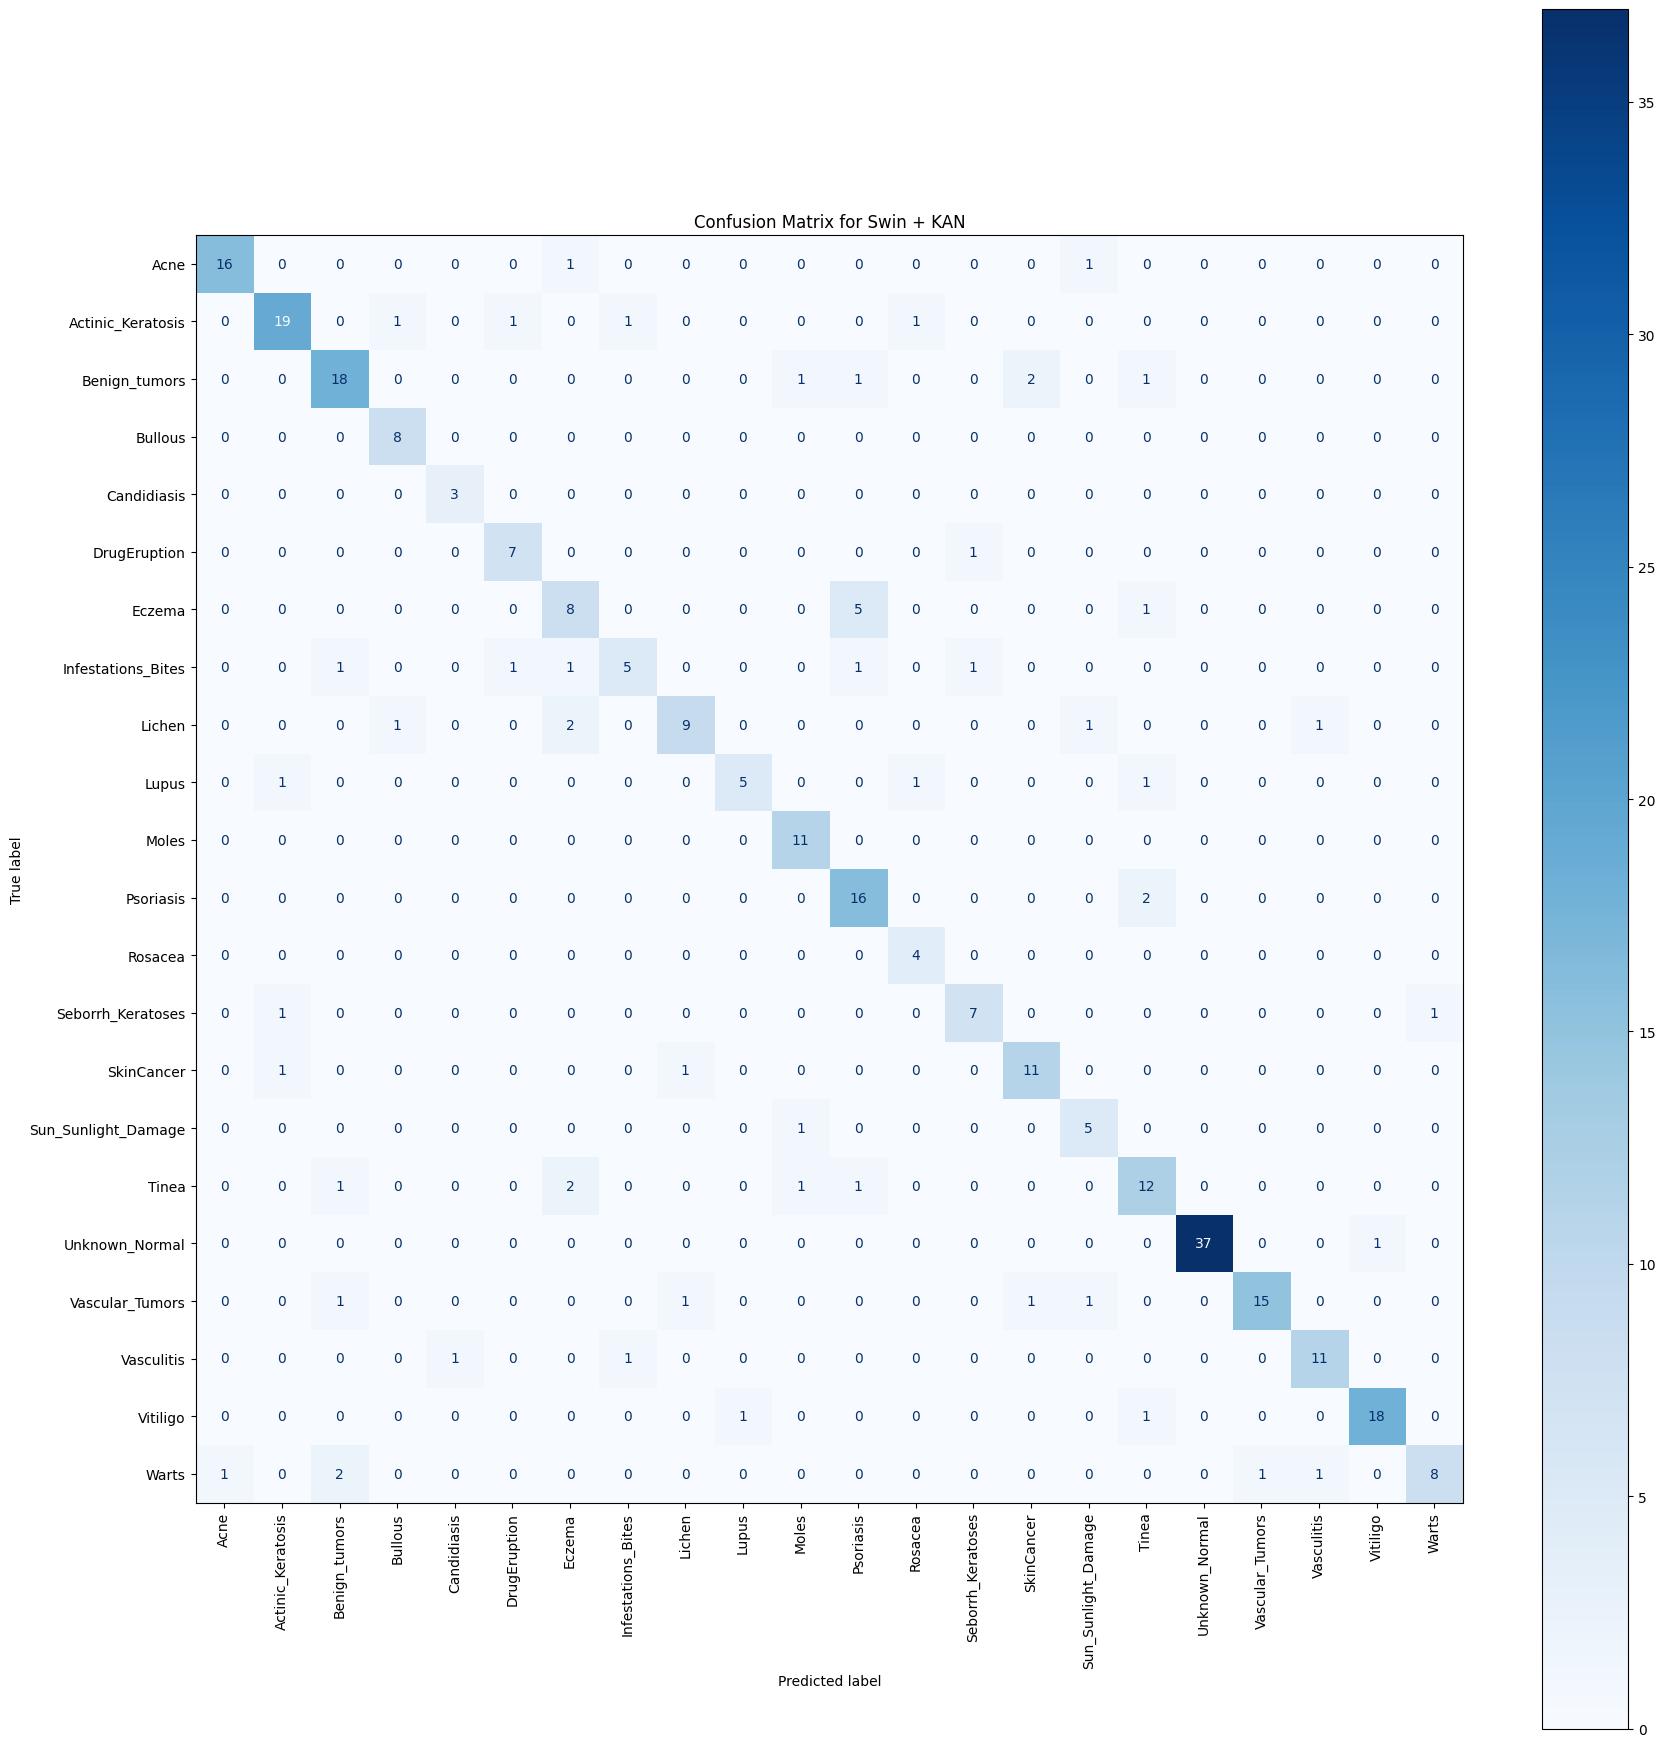

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n=== Final evaluation on the hold-out test set ===")

# 1) Sanity check: make sure trainer and datasets exist
assert "trainer_stageB" in globals(), "trainer_stageB is not defined. Run the training cell first."
assert "processed_dataset" in globals(), "processed_dataset is not defined. Run the dataset preprocessing cell."
assert "dataset" in globals(), "dataset is not defined. Run the dataset loading cell."

# 2) Evaluate on the test set
results = trainer_stageB.evaluate(eval_dataset=processed_dataset["test"])
print("\n--- Final Test Set Metrics (KAN) ---")
for k, v in results.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")
print("----------------------------\n")

# 3) Get predictions for confusion matrix
print("Generating predictions for confusion matrix...")
predictions_output = trainer_stageB.predict(processed_dataset["test"])

logits = predictions_output.predictions
y_true = predictions_output.label_ids

# Basic sanity checks
print("logits shape:", None if logits is None else logits.shape)
print("y_true shape:", None if y_true is None else y_true.shape)

if logits is None or y_true is None:
    raise RuntimeError(
        "Trainer did not return logits or label_ids. "
        "Check that your test split actually has labels and that Trainer is configured correctly."
    )

y_pred = np.argmax(logits, axis=-1)

assert len(y_pred) == len(y_true), "Predictions and labels length mismatch."

# 4) Class names for display
class_names = dataset["test"].features["label"].names
print("Number of classes:", len(class_names))
print("Classes:", class_names)

# 5) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

fig, ax = plt.subplots(figsize=(18, 18))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix for Swin + KAN")
plt.tight_layout()
plt.show()


In [ ]:
# finetuneswin_with_KAN.py
# Colab-ready script that reproduces your original finetune pipeline but
# replaces Swin MLP's fc1 with KAN (spline correction) and runs a 2-stage fine-tune.
# Keeps dataset splitting, metrics, Trainer args, W&B logging, and evaluation identical
# to the original `finetuneswin.py` you provided. See original file for baseline. # :contentReference[oaicite:1]{index=1}



# ====== Final evaluation & confusion matrix (same as baseline) ======
# print("\nPerforming final evaluation on the unseen hold-out test set...")
# # Ensure trainer_stageB is defined by running the preceding training cell first.
# results = trainer_stageB.evaluate(eval_dataset=processed_dataset["test"])
# print("\n--- Final Test Set Metrics (KAN) ---")
# print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
# print(f"Test F1-Score: {results['eval_f1']:.4f}")
# print("----------------------------\n")

# print("Generating confusion matrix on the test set...")
# predictions_output = trainer_stageB.predict(processed_dataset["test"])
# y_pred = np.argmax(predictions_output.predictions, axis=1)
# y_true = predictions_output.label_ids
# class_names = dataset["test"].features["label"].names

# cm = confusion_matrix(y_true, y_pred)
# fig, ax = plt.subplots(figsize=(18, 18))
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(ax=ax, xticks_rotation='vertical', cmap='Blues')
# plt.title("Confusion Matrix for Swin + KAN")
# plt.show()

# ====== Inference example (same idea as baseline) ======
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image

MODEL_PATH = None  # optional: set to a saved checkpoint path if you want to load
IMAGE_PATH = "/content/drive/MyDrive/candidiasis-large-skin-folds-175.jpeg"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if MODEL_PATH:
    print(f"Loading model from: {MODEL_PATH}")
    processor = AutoImageProcessor.from_pretrained(MODEL_PATH)
    model = AutoModelForImageClassification.from_pretrained(MODEL_PATH).to(device)
else:
    processor = image_processor

try:
    image = Image.open(IMAGE_PATH).convert("RGB")
except FileNotFoundError:
    print(f"Image not found at {IMAGE_PATH}, skipping example inference.")
    image = None

if image is not None:
    inputs = processor(images=image, return_tensors="pt").to(device)
    model.to(device).eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = model.config.id2label[predicted_class_idx]
    print("\n--- Prediction Result (KAN model) ---")
    print(f"The model predicts this image is: {predicted_class}")

print("Script finished.")


NameError: name 'torch' is not defined